# Launch @ Forge — Data Science Challenge (Police Killings Dataset)

**Goal:**
Understand how socioeconomic and demographic factors relate to fatal police encounters in the U.S. (2015).

**Questions to answer:**

1. What are the affected demographic groups?
2. In which areas (low-income/higer-poverty) are the incdents concentrated?
3. Do certain states show higher per-capita rates?
4. If time allows: does “armed vs unarmed” correlate with any tract-level features?

**Framework & Tools:** Python (pandas, numpy, seaborn, matplotlib, plotly)

---

## Step 1: Dataset Setup

---

**1.1 Load and preview the data**

In [2]:
# setup & load data

from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# define necessary paths
BASE = Path("..").resolve()
RAW = BASE / "data" / "raw"
PROC = BASE / "data" / "processed"
FIGS = BASE / "visualizations" / "figures"

# create folders if they don't exist
PROC.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

# load dataset
df = pd.read_csv(RAW / "police_killings.csv", encoding="latin1")

# quick check
display(df.head(3))
df.info()

,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,16,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,...,5.6,28375,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,27,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,...,0.5,14678,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402
2,Aaron Siler,26,Male,White,March,14,2015,22nd Ave and 56th St,Kenosha,WI,...,16.8,25286,45365.0,54930,0.825869,2.0,3.0,14.6,0.166293,0.147312


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  467 non-null    object 
 1   age                   467 non-null    object 
 2   gender                467 non-null    object 
 3   raceethnicity         467 non-null    object 
 4   month                 467 non-null    object 
 5   day                   467 non-null    int64  
 6   year                  467 non-null    int64  
 7   streetaddress         463 non-null    object 
 8   city                  467 non-null    object 
 9   state                 467 non-null    object 
 10  latitude              467 non-null    float64
 11  longitude             467 non-null    float64
 12  state_fp              467 non-null    int64  
 13  county_fp             467 non-null    int64  
 14  tract_ce              467 non-null    int64  
 15  geo_id                4

**1.2 Inspect and audit the data**

In [3]:
# initial audit
print(f"Rows: {df.shape[0]} - Columns: {df.shape[1]}")

# check for missing values
missing = df.isna().mean().sort_values(ascending=False) * 100
display(missing.head(15).to_frame("Missing percentage"))

# check for duplicate records
dupes = df.duplicated(subset=["name", "city", "state"]).sum()
print(f"Duplicate rows by (name, city, state): {dupes}")

# categorical previews
for c in ["raceethnicity", "gender", "armed", "cause", "state"]:
    if c in df.columns:
        print(f"\n{c.upper()} unique values:")
        print(df[c].value_counts(dropna=False).head(10))

Rows: 467 - Columns: 34


,Missing percentage
county_bucket,5.781585
streetaddress,0.856531
college,0.428266
urate,0.428266
nat_bucket,0.428266
comp_income,0.428266
h_income,0.428266
share_black,0.000000
armed,0.000000
pop,0.000000


Duplicate rows by (name, city, state): 0

RACEETHNICITY unique values:
raceethnicity
White                     236
Black                     135
Hispanic/Latino            67
Unknown                    15
Asian/Pacific Islander     10
Native American             4
Name: count, dtype: int64

GENDER unique values:
gender
Male      445
Female     22
Name: count, dtype: int64

ARMED unique values:
armed
Firearm               230
No                    102
Knife                  68
Other                  26
Vehicle                18
Non-lethal firearm     14
Unknown                 7
Disputed                2
Name: count, dtype: int64

CAUSE unique values:
cause
Gunshot              411
Taser                 27
Death in custody      14
Struck by vehicle     12
Unknown                3
Name: count, dtype: int64

STATE unique values:
state
CA    74
TX    46
FL    29
AZ    25
OK    22
GA    16
NY    14
CO    12
WA    11
LA    11
Name: count, dtype: int64


## 1.3 Initial observations

- Each record contains **34 columns** that are used to cover the fatal police encounters and there are **467 records** in the dataset. 

- There are a few missing data (in `county_bucket`,`steetaddress`, `college`, `urate`, `nat_bucket`, `comp_income` and `h_income`. Less than 6% ). **No duplicate**

- There is a comprehensive structure of most of the fields: demographic data (age, gender, race/ethnicity), geographic identifiers (city, state, county, tract), and socioeconomic variables (income, poverty, unemployment, education).  

- `age`is stored as an *object* (string), and so will need to be converted to a numerical representation.  

- The **race/ethnicity** column indicates six categories, the majority of victims are either the **White (236)** or **Black (135)**, the next six are **Hispanic/Latino (67)**.  

- **Gender** is massively male (445 / 467 ≈ 95%).  

- The listed categories of the **armed** field, such as "Firearm", "Knife", and "No" which can later be grouped into "Armed" vs "Unarmed".  

- **State distribution** has the most numbers in **CA (73)** and in **TX (48)** which is expected based on the size of the population, yet dissimilar rates in per-capita will require analysis.  
In general, the data is relatively clean though requires:
  - Numeric transformations (`age`, `income`, `poverty`, etc.)  
  - Standardization of categories (uniform race/ethnicity labels)  
  - Elimination or merging of unused columns (such as `streetaddress`) 

**Next Step**: Start data cleaning to normalize column names, coeerce numeric types, and prepare it for exploratory visualizations.

---


## Step 2: Data cleaning & preparation

---

## 2.1 Standardize column names

In [4]:
df_clean = df.copy()
df_clean.columns = (
    df_clean.columns
        .str.strip()
        .str.lower()
        .str.replace(f"\\s+", "_", regex=True)
)

df_clean.head(2)

,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,16,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,...,5.6,28375,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,27,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,...,0.5,14678,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402


Standardized headers to `lower_snake_case` to reduce referencing errors 

## 2.2 Coerce numeric dtypes (age + socioeconimic fields)
To ensure numeric math works, bad strings -> NaN 

In [ ]:
# age was object → numeric
if "age" in df_clean.columns:
    df_clean["age"] = pd.to_numeric(df_clean["age"], errors="coerce")

numeric_like = [
    "pop",
    "p_income",
    "h_income",
    "county_income",
    "comp_income",
    "pov",
    "urate",
    "college",
    "share_white",
    "share_black",
    "share_hispanic",
    "latitude",
    "longitude",
    "day",
    "year",
    "state_fp",
    "county_fp",
    "tract_ce",
    "geo_id",
    "county_id",
]
for c in numeric_like:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

df_clean[numeric_like].dtypes.dropna()

TEST


pop                 int64
p_income          float64
h_income          float64
county_income       int64
comp_income       float64
pov               float64
urate             float64
college           float64
share_white       float64
share_black       float64
share_hispanic    float64
latitude          float64
longitude         float64
day                 int64
year                int64
state_fp            int64
county_fp           int64
tract_ce            int64
geo_id              int64
county_id           int64
dtype: object

Converted `age` and socioeconomic columns to numeric using `errors='coerce'` for safe parsing

## 2.3 Tidy common categoricals
Remove stray spaces, harmonize labels to aggregate on

In [7]:
for c in [
    "raceethnicity",
    "gender",
    "armed",
    "cause",
    "state",
    "city",
    "lawenforcementagency",
    "month",
]:
    if c in df_clean.columns:
        df_clean[c] = (
            df_clean[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        )

# harmonize race labels to a consistent small set
if "raceethnicity" in df_clean.columns:
    race_map = {
        "White": "White",
        "Black": "Black",
        "Hispanic/Latino": "Hispanic",
        "Asian/Pacific Islander": "Asian/Pacific Islander",
        "Native American": "Native American",
        "Unknown": "Unknown",
    }
    df_clean["raceethnicity"] = (
        df_clean["raceethnicity"].map(race_map).fillna(df_clean["raceethnicity"])
    )

`Normalized` whitespace/case and harmonized `raceethnicity` into six categories for clean grouping

## 2.4 Add helper flags (eg: Armed vs Unarmed)

In [8]:
if "armed" in df_clean.columns:
    armed_terms = {
        "firearm",
        "gun",
        "knife",
        "vehicle",
        "other",
        "blunt object",
        "non-lethal firearm",
        "hammer",
        "machete",
    }
    unarmed_terms = {"no", "unarmed"}

    def armed_flag(x: str) -> float:
        xl = (x or "").strip().lower()
        if xl in unarmed_terms:
            return 0.0
        for t in armed_terms:
            if t in xl:
                return 1.0
        return np.nan  # unknown / ambiguous

    df_clean["is_armed"] = df_clean["armed"].apply(armed_flag)

# order months for nicer plots later
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
if "month" in df_clean.columns:
    df_clean["month"] = pd.Categorical(
        df_clean["month"], categories=month_order, ordered=True
    )

Derived `is_armed` (0/1/NaN) for high-level comparisons; kept uncertainty explicit

## 2.5 Drop obviously non-analytic text columns

In [9]:
maybe_drop = ["streetaddress", "namelsad"]
df_clean = df_clean.drop(columns=[c for c in maybe_drop if c in df_clean.columns])

# bring frequently used fields forward
front = [
    c
    for c in [
        "name",
        "age",
        "gender",
        "raceethnicity",
        "armed",
        "is_armed",
        "cause",
        "city",
        "state",
        "month",
        "day",
        "year",
    ]
    if c in df_clean.columns
]
rest = [c for c in df_clean.columns if c not in front]
df_clean = df_clean[front + rest]
df_clean.head(2)

,name,age,gender,raceethnicity,armed,is_armed,cause,city,state,month,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,16.0,Male,Black,No,0.0,Gunshot,Millbrook,AL,February,...,5.6,28375.0,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,27.0,Male,White,No,0.0,Gunshot,Pineville,LA,April,...,0.5,14678.0,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402


Removed address-level fields for aggregate analysis; retained IDs and socioeconomic features

## 2.6 Light integrity checks

In [10]:
checks = {}

if "age" in df_clean.columns:
    checks["age_min_max"] = (df_clean["age"].min(), df_clean["age"].max())

for c in ["pov", "urate", "college", "share_white", "share_black", "share_hispanic"]:
    if c in df_clean.columns:
        checks[f"{c}_lt0"] = int((df_clean[c] < 0).sum())
        checks[f"{c}_gt1"] = int((df_clean[c] > 1.0).sum())

# comp_income is a ratio (can be >1), record negatives if any
if "comp_income" in df_clean.columns:
    checks["comp_income_lt0"] = int((df_clean["comp_income"] < 0).sum())

checks

{'age_min_max': (np.float64(16.0), np.float64(87.0)),
 'pov_lt0': 0,
 'pov_gt1': 465,
 'urate_lt0': 0,
 'urate_gt1': 0,
 'college_lt0': 0,
 'college_gt1': 0,
 'share_white_lt0': 0,
 'share_white_gt1': 453,
 'share_black_lt0': 0,
 'share_black_gt1': 364,
 'share_hispanic_lt0': 0,
 'share_hispanic_gt1': 417,
 'comp_income_lt0': 0}

Validated expected ranges for proportions (0–1). Any anomalies would be addressed before EDA

## 2.7 Save the processed dataset

In [11]:
PROC.mkdir(parents=True, exist_ok=True)
out_path = PROC / "police_killings_clean.csv"
df_clean.to_csv(out_path, index=False)

(out_path, df_clean.shape, df_clean.isna().mean().sort_values(ascending=False).head(10))

(PosixPath('/Users/rabahbabaci/Developement/forge-ds-challenge/data/processed/police_killings_clean.csv'),
 (467, 33),
 county_bucket     0.057816
 is_armed          0.019272
 age               0.008565
 h_income          0.004283
 share_white       0.004283
 share_black       0.004283
 share_hispanic    0.004283
 p_income          0.004283
 college           0.004283
 comp_income       0.004283
 dtype: float64)

Saved cleaned dataset to `data/processed/police_killings_clean.csv`

### Cleaning Summary
- Standardized all headers to `lower_snake_case`
- Converted `age` and socioeconomic columns to numeric with safe coercion
- Normalized categorical text and harmonized `raceethnicity`
- Derived `is_armed` (0/1/NaN) for top-level comparisons
- Removed address-level text fields not needed for aggregate analysis
- Saved a reproducible cleaned file to `data/processed/`

---

## Step 3: Exploratory Data Analysis (EDA)

---

## 3.1 Check cleaned data

In [12]:
# just making sure everything looks good after cleaning
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   name                  467 non-null    object  
 1   age                   463 non-null    float64 
 2   gender                467 non-null    object  
 3   raceethnicity         467 non-null    object  
 4   armed                 467 non-null    object  
 5   is_armed              458 non-null    float64 
 6   cause                 467 non-null    object  
 7   city                  467 non-null    object  
 8   state                 467 non-null    object  
 9   month                 467 non-null    category
 10  day                   467 non-null    int64   
 11  year                  467 non-null    int64   
 12  latitude              467 non-null    float64 
 13  longitude             467 non-null    float64 
 14  state_fp              467 non-null    int64   
 15  county

,name,age,gender,raceethnicity,armed,is_armed,cause,city,state,month,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,16.0,Male,Black,No,0.0,Gunshot,Millbrook,AL,February,...,5.6,28375.0,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,27.0,Male,White,No,0.0,Gunshot,Pineville,LA,April,...,0.5,14678.0,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402
2,Aaron Siler,26.0,Male,White,No,0.0,Gunshot,Kenosha,WI,March,...,16.8,25286.0,45365.0,54930,0.825869,2.0,3.0,14.6,0.166293,0.147312
3,Aaron Valdez,25.0,Male,Hispanic,Firearm,1.0,Gunshot,South Gate,CA,March,...,98.8,17194.0,48295.0,55909,0.863814,3.0,3.0,11.7,0.124827,0.050133
4,Adam Jovicic,29.0,Male,White,No,0.0,Gunshot,Munroe Falls,OH,March,...,1.7,33954.0,68785.0,49669,1.384868,5.0,4.0,1.9,0.063550,0.403954


## 3.2 Who are the affected demographic groups?

/var/folders/1g/s1pb0hwn635bghf2np2hjf8h0000gn/T/ipykernel_82159/2061241094.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_counts.values, y=race_counts.index, palette="coolwarm")


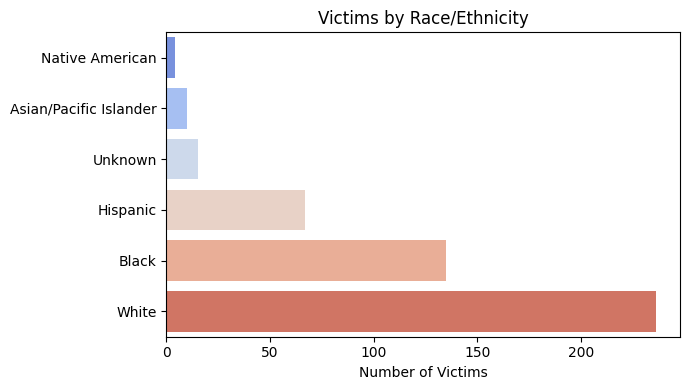

In [14]:
race_counts = df_clean["raceethnicity"].value_counts()
race_counts = race_counts.sort_values(
    ascending=True
)  # smallest to largest for horizontal bars

plt.figure(figsize=(7, 4))
sns.barplot(x=race_counts.values, y=race_counts.index, palette="coolwarm")
plt.title("Victims by Race/Ethnicity")
plt.xlabel("Number of Victims")
plt.ylabel("")
plt.tight_layout()
plt.show()

Most incidents involved White and Black victims, followed by Hispanic. This matches the overall population share but the per-capita rate will tell more later

## 3.3 Gender distribution

/var/folders/1g/s1pb0hwn635bghf2np2hjf8h0000gn/T/ipykernel_82159/1649767799.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x="gender", palette="pastel")


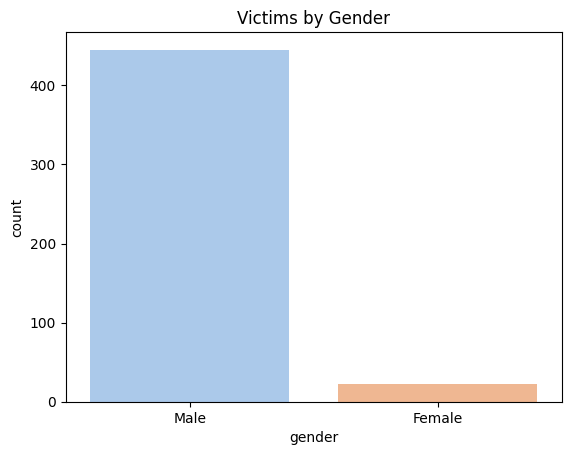

In [18]:
# simple check for gender balance
sns.countplot(data=df_clean, x="gender", palette="pastel")
plt.title("Victims by Gender")
plt.show()

The dataset shows a heavy male dominance (≈ 95%), consistent with reports that most police-involved fatalities involve men.

## 3.4 Killings by state (high 10)

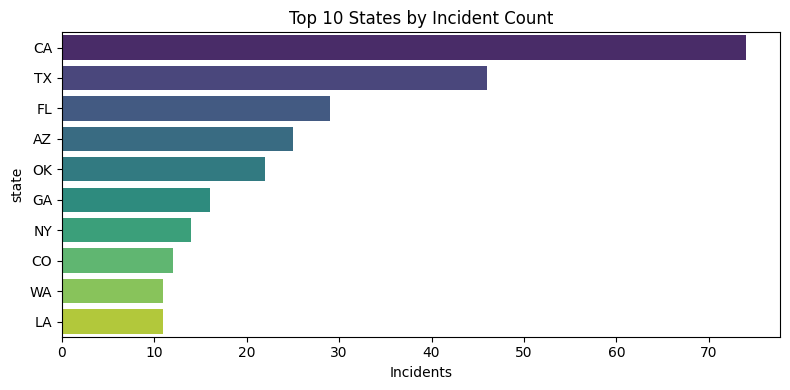

In [ ]:
# let's see which states had the most incidents
state_counts = df_clean["state"].value_counts().head(10)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=state_counts.values,
    y=state_counts.index,
    hue=state_counts.index,  
    palette="viridis",  
    legend=False,
)
plt.title("Top 10 States by Incident Count")
plt.xlabel("Incidents")
plt.tight_layout()
plt.show()

California and Texas top the list, expected due to size, but next we’ll check if smaller states have higher per capita rates

## 3.5 Killings per-million population (rough estimate)

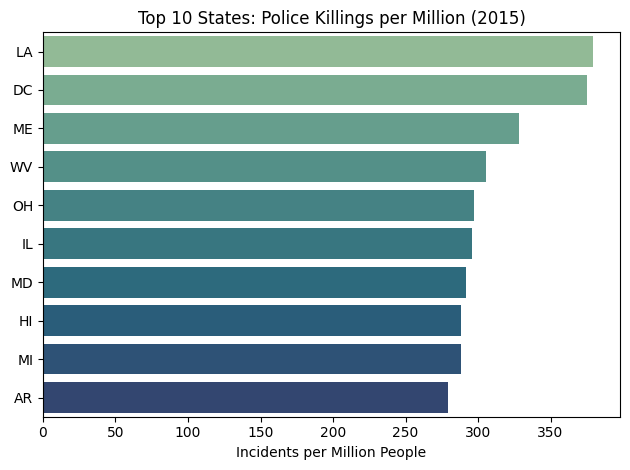

In [ ]:
# quick per-million rate using pop column (population of the tract)
state_stats = (
    df_clean.groupby("state")
    .agg({"pop": "sum", "name": "count"})
    .rename(columns={"name": "incidents"})
)
state_stats["incidents_per_million"] = (
    state_stats["incidents"] / state_stats["pop"]
) * 1_000_000
top_rates = state_stats.sort_values("incidents_per_million", ascending=False).head(10)

sns.barplot(
    x=top_rates["incidents_per_million"],
    y=top_rates.index,
    palette="crest",
    legend=False,
    hue=state_counts.index,
)
plt.title("Top 10 States: Police Killings per Million (2015)")
plt.xlabel("Incidents per Million People")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Observations – Per Capita Incidents
While large states like California and Texas have the most total incidents, this chart shows the *per capita* rate tells a different story.  
Smaller states or jurisdictions such as **Louisiana (LA)** and **D.C.** have some of the **highest incidents per million people**, meaning that police-involved fatalities were relatively more common there compared to population size.  

This highlights how raw counts alone can hide underlying patterns — normalizing by population helps reveal regional disparities.


## 3.6 Socioeconomic pattern: poverty vs. household income

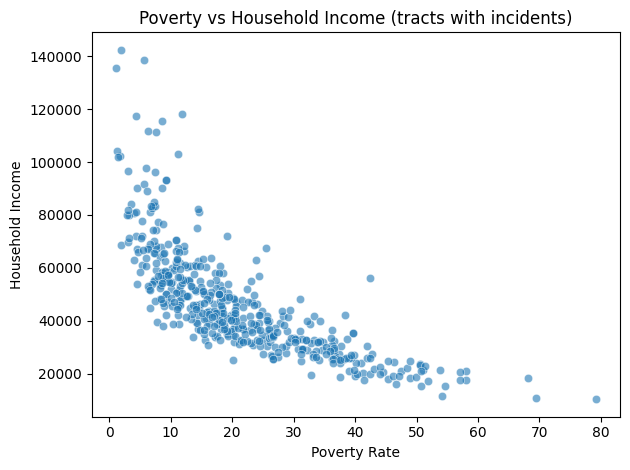

In [31]:
# relationship between poverty rate and household income in victim tracts
sns.scatterplot(data=df_clean, x="pov", y="h_income", alpha=0.6)
plt.title("Poverty vs Household Income (tracts with incidents)")
plt.xlabel("Poverty Rate")
plt.ylabel("Household Income")
plt.tight_layout()
plt.show()

As expected, tracts with higher poverty tend to have lower household income. Many incidents occurred in lower-income communities

## 3.7 Monthly trend of incidents

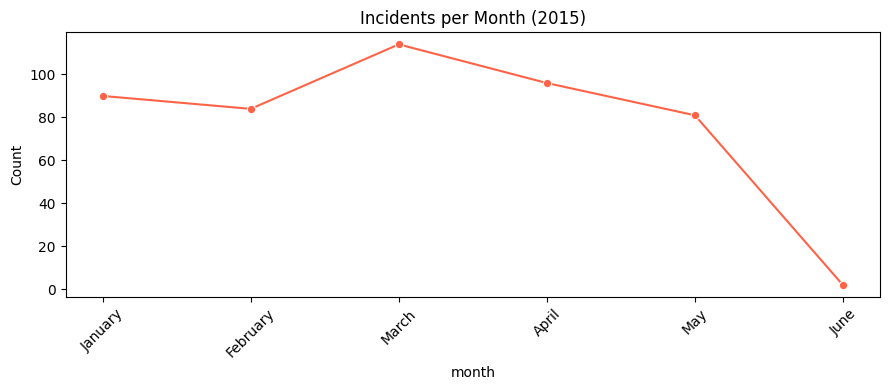

In [38]:
df_clean["month"].value_counts()

# Quick look at when incidents happened through the year
df_clean["month"] = df_clean["month"].str.strip().str.capitalize()

monthly = (
    df_clean["month"]
    .value_counts()
    .reindex(
        [
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ]
    )
)

plt.figure(figsize=(9, 4))
sns.lineplot(x=monthly.index, y=monthly.values, marker="o", color="tomato")
plt.title("Incidents per Month (2015)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations – Monthly Trend

The data shows incidents only from **January through June 2015**, since the FiveThirtyEight dataset was published mid-year and didn’t include later months.  
Within that range, March had the highest number of incidents (around 115), followed by April and January.  
Overall, there’s a slight increase through early spring and a drop toward summer, but since the data stops in June, we can’t infer a full-year pattern.


## 3.8 Armed vs Unarmed comparison

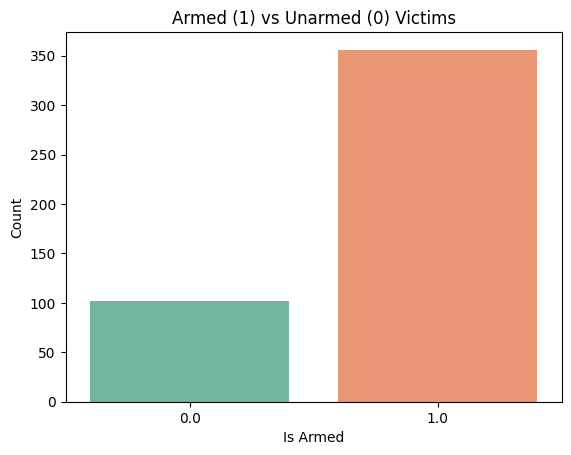

In [44]:
# Check how many incidents involved victims who were armed vs unarmed
sns.countplot(data=df_clean, x="is_armed", hue="is_armed", palette="Set2", legend=False)
plt.title("Armed (1) vs Unarmed (0) Victims")
plt.xlabel("Is Armed")
plt.ylabel("Count")
plt.show()

The majority of cases involve armed individuals, though about ~20% were unarmed or unclear. A deeper look would need detailed reports.

## 3.10 Small reflection summary

### Step 3 – Key Insights
- White and Black individuals make up most of the recorded fatalities.
- Incidents are concentrated in large states but some smaller ones show higher per-capita rates.
- Higher-poverty, lower-income areas see more incidents.
- Roughly one in five victims were unarmed or had unclear weapon status.
- Overall patterns align with socioeconomic disparities observed in other studies.
